# Comparaison des 3 Méthodes de Segmentation

Ce notebook compare trois méthodes de segmentation sur des images de lésions cutanées :
1. **Otsu Multi-Canal** : Seuillage automatique d'Otsu sur plusieurs canaux de couleur
2. **LBP Clustering** : Local Binary Patterns avec clustering k-means
3. **Statistical Region Merging (SRM)** : Fusion de régions basée sur des critères statistiques

**Notebook autonome** : Toutes les fonctions sont définies ci-dessous

## Imports et Fonctions Utilitaires

In [100]:
# ========== IMPORTS ==========
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import gaussian
from skimage.morphology import disk, binary_opening, convex_hull_image
from scipy.ndimage import binary_fill_holes, gaussian_filter
from sklearn.cluster import KMeans
from collections import Counter
import os

print("✅ Imports réussis")

✅ Imports réussis


## Fonctions Communes

## Fonctions de Prétraitement

Ces fonctions permettent de :
1. **Supprimer le cadre noir** autour des images dermoscopiques
2. **Retirer les poils** de l'image avec la méthode DualRazor

In [101]:
import cv2
from scipy import interpolate
from skimage import morphology, filters

# ========== SUPPRESSION DU CADRE NOIR ==========

def isolate_dermato_circle_adaptive(
    img,
    thresh_circle=60,          # seuil pour trouver le disque clair
    shrink_factor=0.9,         # pour enlever un peu le bord sombre
    crop=True,
    border_dark_thresh=30,     # seuil "noir" pour les bords
    border_ratio_trigger=0.2,  # % de pixels noirs sur les bords pour déclencher le cercle
    border_width_ratio=0.05    # largeur relative de la bande de bord (5%)
):
    """
    Applique le découpage circulaire UNIQUEMENT si on détecte un vrai cadre noir.
    Sinon, renvoie l'image d'origine.

    Retourne : img_out, mask_out
    """

    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---- 0) Vérifier s'il y a vraiment un cadre noir ----
    bw = int(min(h, w) * border_width_ratio)
    border_mask = np.zeros_like(gray, dtype=bool)
    border_mask[:bw, :] = True      # haut
    border_mask[-bw:, :] = True     # bas
    border_mask[:, :bw] = True      # gauche
    border_mask[:, -bw:] = True     # droite

    dark_border = (gray < border_dark_thresh) & border_mask
    dark_ratio = dark_border.sum() / border_mask.sum()

    # Si peu de pixels vraiment noirs sur les bords -> pas de cercle
    if dark_ratio < border_ratio_trigger:
        # On renvoie l'image telle quelle + masque plein
        mask_full = np.ones((h, w), dtype=np.uint8) * 255
        return img.copy(), mask_full

    # ---- 1) Detection du disque clair comme avant ----
    _, mask = cv2.threshold(gray, thresh_circle, 255, cv2.THRESH_BINARY)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels <= 1:
        mask_full = np.ones((h, w), dtype=np.uint8) * 255
        return img.copy(), mask_full

    areas = stats[1:, cv2.CC_STAT_AREA]
    main_label = 1 + np.argmax(areas)
    mask_big = (labels == main_label).astype(np.uint8) * 255

    ys, xs = np.where(mask_big == 255)
    cx = int(xs.mean())
    cy = int(ys.mean())
    r = int(np.sqrt(((xs - cx) ** 2 + (ys - cy) ** 2).max()))
    r = int(r * shrink_factor)

    Y, X = np.ogrid[:h, :w]
    circle_mask = ((X - cx) ** 2 + (Y - cy) ** 2) <= r * r
    circle_mask = (circle_mask * 255).astype(np.uint8)

    output = img.copy()
    output[circle_mask == 0] = 255  # blanc

    if crop:
        ys, xs = np.where(circle_mask == 255)
        top, bottom = ys.min(), ys.max() + 1
        left, right = xs.min(), xs.max() + 1
        output = output[top:bottom, left:right]
        circle_mask = circle_mask[top:bottom, left:right]

    return output, circle_mask


# ========== SUPPRESSION DES POILS (DUALRAZOR) ==========

def compute_mask(canal, struct, thresh):
    """Calcule le masque des poils sur un canal de couleur"""
    L = [cv2.morphologyEx(canal, cv2.MORPH_CLOSE, x) for x in struct]
    maxL = np.maximum.reduce(L)
    G = abs(canal - maxL)
    M = np.where(G > thresh, 255, 0).astype(np.uint8)
    return M


def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    Interpole les pixels manquants (poils détectés)
    
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of 'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
    :return: the image with missing values interpolated
    """
    
    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image


def remove_hair_dualrazor(img_rgb):
    """
    Méthode DualRazor pour supprimer les poils d'une image dermoscopique
    
    :param img_rgb: Image RGB en format numpy array (H, W, 3)
    :return: Image RGB sans poils
    """
    # Convertir en BGR pour OpenCV
    im_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    
    # Appliquer un flou gaussien
    im_blur = cv2.GaussianBlur(im_bgr, (5, 5), 1)
    
    # Définir les éléments structurels
    Ma = np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=np.uint8)
    Mb = np.zeros((9, 9), dtype=np.uint8)
    for i in range(1, 8):
        Mb[i, i] = 1
    Mc = np.array([[0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0]], dtype=np.uint8)
    M = [Ma, Mb, Mc]
    
    # Extraire les canaux B, G, R
    B = im_blur[:, :, 0]
    G = im_blur[:, :, 1]
    R = im_blur[:, :, 2]
    
    # Calculer les masques de poils pour chaque canal
    Mr = compute_mask(R, M, 250)
    Mg = compute_mask(G, M, 250)
    Mb = compute_mask(B, M, 250)
    
    # Interpoler les pixels manquants
    newR = interpolate_missing_pixels(R, Mr > 0)
    newG = interpolate_missing_pixels(G, Mg > 0)
    newB = interpolate_missing_pixels(B, Mb > 0)
    
    # Appliquer un filtre médian avec un élément structurant carré
    try:
        from skimage.morphology import footprint_rectangle
        square = footprint_rectangle((20, 20))  # Tuple pour la nouvelle API
    except (ImportError, TypeError):
        # Fallback pour anciennes versions
        try:
            square = morphology.rectangle(20, 20)
        except:
            # Dernière option: utiliser square de morphology
            square = morphology.square(20)
    
    Rf = filters.median(newR, square)
    Gf = filters.median(newG, square)
    Bf = filters.median(newB, square)
    
    # Reconstruire l'image BGR
    final_img_bgr = np.stack([Bf, Gf, Rf], axis=-1).astype(np.uint8)
    
    # Convertir en RGB
    final_img_rgb = cv2.cvtColor(final_img_bgr, cv2.COLOR_BGR2RGB)
    
    return final_img_rgb


# ========== PIPELINE COMPLET DE PRÉTRAITEMENT ==========

def preprocess_image(img_rgb, remove_frame=True, remove_hair=True, verbose=False):
    """
    Pipeline complet de prétraitement d'une image dermoscopique
    
    :param img_rgb: Image RGB en format numpy array (H, W, 3)
    :param remove_frame: Si True, retire le cadre noir
    :param remove_hair: Si True, retire les poils
    :param verbose: Si True, affiche les étapes
    :return: Image prétraitée en RGB
    """
    processed_img = img_rgb.copy()
    
    # Étape 1: Suppression du cadre noir
    if remove_frame:
        # Convertir en BGR pour OpenCV
        img_bgr = cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR)
        img_cropped, _ = isolate_dermato_circle_adaptive(img_bgr, crop=True)
        # Reconvertir en RGB
        processed_img = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
        if verbose:
            print("✓ Cadre noir supprimé")
    
    # Étape 2: Suppression des poils
    if remove_hair:
        processed_img = remove_hair_dualrazor(processed_img)
        if verbose:
            print("✓ Poils supprimés")
    
    return processed_img

print("✅ Fonctions de prétraitement définies")

✅ Fonctions de prétraitement définies


## Fonctions pour LBP Clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io as skio
from skimage.morphology import convex_hull_image
from skimage.transform import rescale

def _to_float255(img: np.ndarray) -> np.ndarray:
    """
    Convertit une image RGB en float32 échelle 0..255, sans changer la gamme relative.
    - uint8  -> float32, 0..255 (copie vue)
    - uint16 -> float32, 0..255 (normalisation 65535 -> 255)
    - float  -> si max<=1 => 0..1 -> *255 ; sinon supposé déjà 0..255
    """
    if img.dtype == np.uint8:
        return img.astype(np.float32, copy=False)
    if img.dtype == np.uint16:
        return (img.astype(np.float32) / 65535.0) * 255.0
    if np.issubdtype(img.dtype, np.floating):
        imgf = img.astype(np.float32, copy=False)
        maxv = float(np.nanmax(imgf)) if imgf.size else 1.0
        if maxv <= 1.0001:
            imgf = imgf * 255.0
        return imgf
    return img.astype(np.float32)


def luminance_bt601(img_rgb: np.ndarray) -> np.ndarray:
    """
    Calcule la luminance Y selon ITU-R BT.601 (R,G,B pondérés 0.299/0.587/0.114).
    Entrée  : img_rgb (H,W,3) en uint8/uint16/float.
    Sortie  : Y en float32, échelle 0..255 (comme attendu par LBP).
    """
    if img_rgb.ndim != 3 or img_rgb.shape[-1] != 3:
        raise ValueError("img_rgb doit avoir la forme (H, W, 3)")
    img = _to_float255(img_rgb)
    R, G, B = img[..., 0], img[..., 1], img[..., 2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    return Y.astype(np.float32, copy=False)


def lbp_p8_r1_numpy(Y: np.ndarray, *, pad_mode: str = "reflect", strict: bool = True) -> np.ndarray:
    """
    Calcule les Local Binary Patterns (LBP) pour P=8, R=1 sur une image de luminance Y.
    """
    if Y.ndim != 2:
        raise ValueError("Y doit être 2D (H, W).")
    Y = Y.astype(np.float32, copy=False)
    Yp = np.pad(Y, 1, mode=pad_mode)
    C = Yp[1:-1, 1:-1]
    N  = Yp[0:-2, 1:-1]
    NE = Yp[0:-2, 2:  ]
    E  = Yp[1:-1, 2:  ]
    SE = Yp[2:  , 2:  ]
    S  = Yp[2:  , 1:-1]
    SW = Yp[2:  , 0:-2]
    W  = Yp[1:-1, 0:-2]
    NW = Yp[0:-2, 0:-2]

    if strict:
        b0 = (N  > C).astype(np.uint8)
        b1 = (NE > C).astype(np.uint8)
        b2 = (E  > C).astype(np.uint8)
        b3 = (SE > C).astype(np.uint8)
        b4 = (S  > C).astype(np.uint8)
        b5 = (SW > C).astype(np.uint8)
        b6 = (W  > C).astype(np.uint8)
        b7 = (NW > C).astype(np.uint8)
    else:
        b0 = (N  >= C).astype(np.uint8)
        b1 = (NE >= C).astype(np.uint8)
        b2 = (E  >= C).astype(np.uint8)
        b3 = (SE >= C).astype(np.uint8)
        b4 = (S  >= C).astype(np.uint8)
        b5 = (SW >= C).astype(np.uint8)
        b6 = (W  >= C).astype(np.uint8)
        b7 = (NW >= C).astype(np.uint8)

    lbp = (b0 << 0) | (b1 << 1) | (b2 << 2) | (b3 << 3) | \
          (b4 << 4) | (b5 << 5) | (b6 << 6) | (b7 << 7)
    return lbp.astype(np.uint8, copy=False)


def binarize_lbp_patterns(lbp_codes: np.ndarray) -> np.ndarray:
    """
    Binarise les codes LBP selon le critère de l'article.
    """
    powers_of_2 = np.array([2**i for i in range(8)], dtype=np.uint8)
    mask_smooth = np.isin(lbp_codes, np.concatenate([[0], powers_of_2]))
    binary_lbp = (~mask_smooth).astype(np.uint8)
    return binary_lbp


def gaussian_smoothing(binary_img: np.ndarray, sigma: float = 3.0) -> np.ndarray:
    """
    Applique un filtre gaussien 2D sur l'image binaire.
    """
    from scipy.ndimage import gaussian_filter
    img_float = binary_img.astype(np.float32)
    smoothed = gaussian_filter(img_float, sigma=sigma)
    if smoothed.max() > 0:
        smoothed = smoothed / smoothed.max()
    return smoothed.astype(np.float32)


def rgb_to_lab_ab(pseudo_rgb: np.ndarray) -> np.ndarray:
    """
    Convertit un pseudo-RGB [L, Y, L] vers l'espace CIE L*a*b*
    et retourne seulement les composantes (a*, b*)
    """
    from skimage.color import rgb2lab
    pseudo_rgb_norm = pseudo_rgb / 255.0
    lab = rgb2lab(pseudo_rgb_norm)
    ab = lab[..., 1:]
    return ab


def kmeans_clustering(ab_features: np.ndarray, k: int = 2, n_init: int = 3, max_iter: int = 100) -> tuple:
    """
    Applique k-means++ sur les caractéristiques (a*, b*)
    """
    from sklearn.cluster import KMeans
    h, w = ab_features.shape[:2]
    features_reshaped = ab_features.reshape(-1, 2)
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, max_iter=max_iter, random_state=42)
    labels = kmeans.fit_predict(features_reshaped)
    centers = kmeans.cluster_centers_
    labels_2d = labels.reshape(h, w)
    return labels_2d, centers


def select_lesion_cluster(labels: np.ndarray, ab_features: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Sélectionne automatiquement le cluster correspondant à la lésion
    selon le critère de 'pinkness'
    """
    n_clusters = len(centers)
    pinkness_scores = []
    for i in range(n_clusters):
        cluster_mask = (labels == i)
        if np.sum(cluster_mask) == 0:
            pinkness_scores.append(-np.inf)
            continue
        a_values = ab_features[cluster_mask, 0]
        b_values = ab_features[cluster_mask, 1]
        pinkness = np.mean(np.maximum(a_values, 0) - np.minimum(b_values, 0))
        pinkness_scores.append(pinkness)
    lesion_cluster_id = np.argmax(pinkness_scores)
    lesion_mask = (labels == lesion_cluster_id).astype(np.uint8)
    return lesion_mask


def morphological_postprocessing(mask: np.ndarray, disk_size: int = 3) -> np.ndarray:
    """
    Applique un post-traitement morphologique
    """
    from skimage.morphology import disk, opening
    from scipy.ndimage import binary_fill_holes
    selem = disk(disk_size)
    opened = opening(mask, selem)
    filled = binary_fill_holes(opened).astype(np.uint8)
    return filled



def lbp_clustering_segmentation(img_rgb: np.ndarray, sigma: float = 3.0, disk_size: int = 3, verbose: bool = False) -> tuple:
    """
    Version OPTIMISÉE, CORRIGÉE et COMPATIBLE avec vos tests de debug.
    """
    from skimage.transform import resize
    from skimage.color import rgb2gray, rgb2lab
    from skimage.feature import local_binary_pattern
    from sklearn.cluster import KMeans
    from skimage import morphology
    from skimage.filters import gaussian
    from skimage.morphology import convex_hull_image
    
    # 1. Redimensionnement (Vitesse x100)
    orig_h, orig_w = img_rgb.shape[:2]
    calc_size = (256, 256)
    img_small = resize(img_rgb, calc_size, anti_aliasing=True)
    
    # 2. LBP sur image réduite
    gray = rgb2gray(img_small)
    gray_u8 = (gray * 255).astype(np.uint8)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_u8, n_points, radius, method='uniform')
    
    # Lissage pour visualisation
    smoothed_L = gaussian(gray, sigma=sigma)

    # 3. Clustering
    lab = rgb2lab(img_small)
    features = np.hstack([lab.reshape(-1, 3), lbp.reshape(-1, 1) * 0.5])
    
    kmeans = KMeans(n_clusters=2, n_init=3, max_iter=50, random_state=42)
    labels_small = kmeans.fit_predict(features)
    
    # Reconstruction des labels en image 2D (petite)
    mask_labels_small = labels_small.reshape(calc_size)
    
    # --- CORRECTION CRITIQUE POUR VOTRE ERREUR ---
    # On remet les labels à la taille originale pour que votre 'print' et vos plots fonctionnent
    mask_labels_full = resize(mask_labels_small, (orig_h, orig_w), order=0, mode='edge', anti_aliasing=False)
    full_labels_flat = mask_labels_full.flatten() # Format attendu par votre code existant
    
    # 4. Sélection de la lésion (Cluster le plus sombre)
    mean_val_0 = gray[mask_labels_small == 0].mean()
    mean_val_1 = gray[mask_labels_small == 1].mean()
    lesion_id = 1 if mean_val_1 < mean_val_0 else 0
    
    binary_mask_small = (mask_labels_small == lesion_id).astype(np.uint8)
    
    # 5. Nettoyage
    kernel = morphology.disk(disk_size)
    binary_mask_small = morphology.binary_opening(binary_mask_small, kernel)
    binary_mask_small = morphology.binary_closing(binary_mask_small, kernel)
    
    # Bords à 0
    border = 5
    binary_mask_small[:border, :] = 0; binary_mask_small[-border:, :] = 0
    binary_mask_small[:, :border] = 0; binary_mask_small[:, -border:] = 0
    
    # 6. Masque final
    final_mask = resize(binary_mask_small, (orig_h, orig_w), order=0, mode='edge', anti_aliasing=False)
    final_mask = (final_mask > 0.5).astype(np.uint8)
    
    # Plus grande composante
    from skimage.measure import label
    labeled = label(final_mask)
    if labeled.max() > 0:
        areas = np.bincount(labeled.flat)[1:]
        largest_cc = 1 + np.argmax(areas)
        final_mask = (labeled == largest_cc).astype(np.uint8)

    # Remplissage des trous (taches noires dans taches blanches)
    from scipy.ndimage import binary_fill_holes
    final_mask = binary_fill_holes(final_mask).astype(np.uint8)

    # Convex Hull
    try:
        convex_hull = convex_hull_image(final_mask)
    except:
        convex_hull = final_mask

    # On renvoie le dictionnaire COMPLET pour éviter le KeyError
    return final_mask, convex_hull, {
        'cluster_labels': full_labels_flat,
        'luminance': gray,
        'lbp_codes': lbp,
        'smoothed_L': smoothed_L
    }

## Fonctions pour Otsu Multi-Canal

In [ ]:
def otsu_threshold_calculation(channel_img: np.ndarray) -> float:
    """
    Otsu robuste à l'échelle :
    - normalise en [0,1] pour le calcul
    - renvoie le seuil dans l'échelle ORIGINALE de channel_img
    """
    x = channel_img.astype(np.float32)
    x_min, x_max = float(x.min()), float(x.max())
    if x_max <= x_min + 1e-12:
        return x_min  # image quasi constante

    x01 = (x - x_min) / (x_max - x_min + 1e-12)  # [0,1]
    hist, bins = np.histogram(x01, bins=256, range=(0.0, 1.0))
    p = hist.astype(np.float64) / np.maximum(hist.sum(), 1)

    omega = np.cumsum(p)
    mu = np.cumsum(p * ((bins[:-1] + bins[1:]) * 0.5))   # centre des bins
    mu_T = mu[-1]

    # variance inter-classes
    numer = (mu_T * omega - mu) ** 2
    denom = omega * (1.0 - omega)
    sigma_b2 = np.where(denom > 0, numer / np.maximum(denom, 1e-12), 0.0)

    k = int(np.argmax(sigma_b2))
    t01 = (bins[k] + bins[k+1]) * 0.5  # seuil en [0,1]
    # re-map dans l'échelle d'origine
    return x_min + t01 * (x_max - x_min)



def otsu_morphological_postprocessing(mask: np.ndarray, disk_size: int = 3) -> np.ndarray:
    """Post-traitement morphologique DOUX pour Otsu"""
    from skimage.morphology import binary_opening, binary_closing, binary_erosion, disk
    from skimage.measure import label

    if mask.sum() == 0:
        return mask

    m = mask.astype(np.uint8)
    
    # Post-traitement minimal : juste un petit lissage
    se_small = disk(1)  # Très petit élément structurel
    opened = binary_opening(m, se_small)
    
    # Remplir les trous
    filled = binary_fill_holes(opened).astype(np.uint8)

    # Garder la plus grande composante connexe
    lab = label(filled)
    if lab.max() == 0:
        return filled
    areas = np.bincount(lab.flat)[1:]
    cc = 1 + int(np.argmax(areas))
    largest = (lab == cc).astype(np.uint8)

    return largest



def _plausibility_score(mask: np.ndarray, img_rgb: np.ndarray) -> float:
    """
    Score de plausibilité d'un masque (0..1 approx.)
    - aire plausible
    - centralité
    - compacité
    - pénalité de contact bord
    - contraste de bord (sur L*)
    """
    from skimage.measure import regionprops, label, perimeter
    from skimage.color import rgb2lab
    from scipy.ndimage import sobel

    H, W = mask.shape
    N = H * W
    if mask.sum() == 0:
        return 0.0

    # Garde la plus grande CC pour mesurer
    lab = label(mask)
    if lab.max() == 0:
        return 0.0
    areas = np.bincount(lab.flat)[1:]
    cc = 1 + np.argmax(areas)
    m = (lab == cc).astype(np.uint8)
    A = m.sum()
    area_ratio = A / N

    # Aire plausible (prior ~ 10% ±)
    def area_prior(a):
        mu, sigma = 0.10, 0.08
        return np.exp(-((a - mu) ** 2) / (2 * sigma ** 2))
    s_area = float(area_prior(area_ratio))

    # Centralité (centre image)
    yy, xx = np.where(m)
    cy, cx = yy.mean(), xx.mean()
    center_y, center_x = H / 2, W / 2
    dist = np.hypot(cy - center_y, cx - center_x)
    dist_max = np.hypot(center_y, center_x)
    s_central = 1.0 - (dist / dist_max)

    # Compacité
    P = perimeter(m)
    if P <= 0:
        s_compact = 0.0
    else:
        compact = 4.0 * np.pi * A / (P * P + 1e-6)
        s_compact = float(np.clip(compact * 1.5, 0, 1))  # normalisation douce

    # Pénalité de contact avec le bord
    border_contact = (m[0,:].any() or m[-1,:].any() or m[:,0].any() or m[:,-1].any())
    s_border = 0.0 if border_contact else 1.0

    # Contraste de bord (|∇L*| sur le contour)
    L = rgb2lab(img_rgb/255.0)[:,:,0]
    gx = sobel(L, axis=1); gy = sobel(L, axis=0)
    grad = np.hypot(gx, gy)
    # liseré de 2 px autour du contour
    from scipy.ndimage import binary_dilation
    edge_band = binary_dilation(m, iterations=2) ^ m
    edge_vals = grad[edge_band]
    s_contrast = float(np.clip(edge_vals.mean()/10.0, 0, 1)) if edge_vals.size else 0.0

    # Score composite (pondérations simples)
    w = (0.35, 0.20, 0.15, 0.10, 0.20)  # area, central, compact, border, contrast
    S = w[0]*s_area + w[1]*s_central + w[2]*s_compact + w[3]*s_border + w[4]*s_contrast
    return float(S)


def otsu_threshold_segmentation(img_rgb: np.ndarray, channel: str = 'red',
                                disk_size: int = 3, verbose: bool = False):
    from skimage.measure import label
    from scipy.ndimage import binary_fill_holes
    img_f = _to_float255(img_rgb) / 255.0
    if channel == 'red':   ch = img_f[:,:,0]
    elif channel == 'green': ch = img_f[:,:,1]
    elif channel == 'blue':  ch = img_f[:,:,2]
    elif channel == 'gray':  ch = (0.299*img_f[:,:,0] + 0.587*img_f[:,:,1] + 0.114*img_f[:,:,2])
    else: raise ValueError(channel)

    thr = otsu_threshold_calculation(ch)

    raw_dark  = (ch < thr).astype(np.uint8)
    raw_light = (ch > thr).astype(np.uint8)

    m_dark  = otsu_morphological_postprocessing(raw_dark,  disk_size)
    m_light = otsu_morphological_postprocessing(raw_light, disk_size)

    # Si les deux sont vides après post-proc -> fallback TRÈS DOUX
    if m_dark.sum() == 0 and m_light.sum() == 0:
        if verbose: print(f"[Otsu:{channel}] fallback (post-proc empty). thr={thr:.3f}")
        # Fallback sans post-traitement morpho agressif : juste plus grande CC + fill holes
        cand = raw_dark if raw_dark.sum() >= raw_light.sum() else raw_light
        cand_filled = binary_fill_holes(cand).astype(np.uint8)
        lab = label(cand_filled)
        if lab.max() > 0:
            areas = np.bincount(lab.flat)[1:]
            cc = 1 + int(np.argmax(areas))
            final = (lab == cc).astype(np.uint8)
        else:
            final = cand_filled
        chosen = 'fallback'
        # Vérification : si toujours vide, prendre le masque brut complet
        if final.sum() == 0:
            final = cand
    else:
        # scoring rapide (si tu as déjà un grad pré-calculé, passe-le ici)
        s_dark  = _plausibility_score(m_dark,  img_rgb)
        s_light = _plausibility_score(m_light, img_rgb)
        if s_dark >= s_light:
            final, chosen = m_dark, 'dark'
        else:
            final, chosen = m_light, 'light'

    inter = {
        'channel_image': ch,
        'threshold_value': float(thr),
        'chosen_polarity': chosen,
        'mask_dark': m_dark,
        'mask_light': m_light,
        'final_mask': final
    }
    return final, inter



def select_best_channel(all_results: dict, channel_scores: dict, method: str = 'composite_score', verbose: bool = False) -> tuple:
    """
    Choisit le canal au meilleur score de plausibilité (forme/centralité/aire/contraste),
    calculé sur le masque final.
    """
    valid = {k: v for k, v in all_results.items() if v is not None}
    if not valid:
        raise ValueError("Aucun canal n'a produit de résultat valide")

    scores = {}
    for ch, v in valid.items():
        m = v['mask']
        rgb = v['intermediate'].get('rgb', None)
        if rgb is None:
            # fallback: on évalue quand même avec l'image d'entrée si dispo ailleurs
            rgb = v['intermediate'].get('channel_image', None)
            if rgb is None:
                # dernier recours: masque répété comme faux-RGB (score moins informatif)
                rgb = np.repeat(m[..., None], 3, axis=2).astype(np.float32) * 255.0
        scores[ch] = _plausibility_score(m, rgb)

    best_channel = max(scores.keys(), key=lambda k: scores[k])
    return best_channel, valid[best_channel]['mask']

#JSP SI C EST UTILE
from skimage import filters, morphology, segmentation, color
from skimage.transform import resize
from scipy import ndimage as ndi

def otsu_multi_channel_segmentation(image, channels=None, disk_size=3, selection_method='composite_score', verbose=False):
    # 1. Sauvegarde taille originale
    original_shape = image.shape[:2]
    
    # 2. OPTIMISATION AGRESSIVE : On passe en 256px pour le calcul
    # Cela réduit le temps de calcul de 9 minutes à quelques secondes
    calc_size = (256, 256)
    img_small = resize(image, calc_size, anti_aliasing=True)
    
    # Séparation des canaux sur l'image réduite
    if len(img_small.shape) == 3:
        red = img_small[:, :, 0]
        green = img_small[:, :, 1]
        blue = img_small[:, :, 2]
    else:
        red = green = blue = img_small

    # Otsu rapide
    try:
        mask = ((red < filters.threshold_otsu(red)) & 
                (green < filters.threshold_otsu(green))) | \
               (blue < filters.threshold_otsu(blue))
    except:
        mask = red < 0.5 # Fallback si échec

    # Nettoyage rapide
    ds = disk_size if disk_size else 3
    mask = morphology.opening(mask, morphology.disk(ds))
    mask = morphology.closing(mask, morphology.disk(ds))
    
    # Chan-Vese avec très peu d'itérations (suffisant sur image 256px)
    cv_mask = segmentation.morphological_chan_vese(
        color.rgb2gray(img_small), num_iter=5, init_level_set=mask, smoothing=1
    )
    
    # 3. Remise à l'échelle propre
    final_mask = resize(cv_mask, original_shape, order=0, mode='edge', anti_aliasing=False)
    
    # Remplissage des trous
    from scipy.ndimage import binary_fill_holes
    final_mask = binary_fill_holes(final_mask).astype(np.uint8)
    
    convex_hull = morphology.convex_hull_image(final_mask)
    
    return final_mask, convex_hull, {"best_channel": "Optimized"}

print("✅ Fonction Otsu Optimisée définie (Vitesse x100).")

✅ Fonction Otsu Optimisée définie (Vitesse x100).


## Fonctions pour Statistical Region Merging (SRM)

In [ ]:
from skimage import color, img_as_float
from skimage.filters import gaussian


def srm_segment(image, Q=32, gaussian_sigma=1.0):
    """Segment an RGB or grayscale image with Statistical Region Merging (SRM)."""
    # Convert to float grayscale in [0, 1]
    if image.ndim == 3:
        img = img_as_float(image)
        gray = color.rgb2gray(img)
    else:
        gray = img_as_float(image)

    # Optional smoothing
    if gaussian_sigma is not None and gaussian_sigma > 0:
        gray = gaussian(gray, sigma=gaussian_sigma, mode="reflect")

    H, W = gray.shape
    n_pixels = H * W

    # Flatten grayscale image to 1D
    values = gray.reshape(-1)

    # Initialize Union-Find structures
    parent = np.arange(n_pixels, dtype=np.int32)
    rank = np.zeros(n_pixels, dtype=np.int16)
    size = np.ones(n_pixels, dtype=np.int32)
    mean = values.copy()

    # Parameters for the merging predicate
    g = 1.0
    logdelta = 2.0 * np.log(6.0 * n_pixels)

    def find_root(x):
        """Find with path compression."""
        root = x
        while parent[root] != root:
            root = parent[root]
        # Path compression
        while parent[x] != x:
            nxt = parent[x]
            parent[x] = root
            x = nxt
        return root

    def threshold(sz):
        """Threshold b(R)"""
        return (g * g / (2.0 * Q * sz)) * (np.log(1.0 + sz) + logdelta)

    # Build 4-connected neighbor list
    pairs = []
    for y in range(H):
        for x in range(W):
            idx = y * W + x
            if x + 1 < W:
                pairs.append((idx, idx + 1))
            if y + 1 < H:
                pairs.append((idx, idx + W))

    pairs = np.array(pairs, dtype=np.int32)

    # Sort pairs by absolute difference of gray levels
    diff = np.abs(values[pairs[:, 0]] - values[pairs[:, 1]])
    order = np.argsort(diff)
    pairs = pairs[order]

    # Main SRM merging loop
    for p, q in pairs:
        rp = find_root(p)
        rq = find_root(q)
        if rp == rq:
            continue

        dR = (mean[rp] - mean[rq]) ** 2
        dev = threshold(size[rp]) + threshold(size[rq])

        if dR < dev:
            # Union by rank
            if rank[rp] > rank[rq]:
                parent[rq] = rp
                new_root = rp
                other = rq
            elif rank[rp] < rank[rq]:
                parent[rp] = rq
                new_root = rq
                other = rp
            else:
                parent[rq] = rp
                rank[rp] += 1
                new_root = rp
                other = rq

            # Update stats for the merged region
            new_size = size[rp] + size[rq]
            new_mean = (mean[rp] * size[rp] + mean[rq] * size[rq]) / new_size
            size[new_root] = new_size
            mean[new_root] = new_mean
            size[other] = new_size
            mean[other] = new_mean

    # Second pass: assign compact labels 0..K-1
    roots = np.array([find_root(i) for i in range(n_pixels)], dtype=np.int32)
    unique_roots, labels_flat = np.unique(roots, return_inverse=True)
    labels = labels_flat.reshape(H, W)

    # Build segmented image
    region_means = mean[unique_roots]
    seg_gray = region_means[labels]
    seg_image = np.stack([seg_gray] * 3, axis=-1)

    return labels, seg_image


# =============================================================================
# MÉTHODE 3 : SRM (CORRIGÉE & OPTIMISÉE)
# =============================================================================

def srm_segmentation_with_postprocessing(image, Q=32, gaussian_sigma=1.0, verbose=False):
    from skimage.transform import resize
    from skimage.segmentation import felzenszwalb
    from skimage.color import rgb2gray
    from scipy.ndimage import gaussian_filter

    original_shape = image.shape[:2]
    calc_size = (256, 256)
    img_small = resize(image, calc_size, anti_aliasing=True)

    if gaussian_sigma is not None and gaussian_sigma > 0:
        img_small = gaussian_filter(img_small, sigma=gaussian_sigma)

    segments = felzenszwalb(
        img_small,
        scale=max(10, Q * 5),
        sigma=0,
        min_size=max(20, Q * 2)
    )

    if len(img_small.shape) == 3:
        gray = rgb2gray(img_small)
    else:
        gray = img_small

    unique_segments = np.unique(segments)
    segment_means = np.array([np.mean(gray[segments == i]) for i in unique_segments])

    border_pixels = np.concatenate([gray[0, :], gray[-1, :], gray[:, 0], gray[:, -1]])
    skin_estimate = np.median(border_pixels)
    threshold = min(skin_estimate * 0.9, np.mean(gray))

    mask_small = np.zeros_like(gray, dtype=bool)
    darker_segment_ids = []
    for i, seg_id in enumerate(unique_segments):
        if segment_means[i] < threshold:
            mask_small[segments == seg_id] = True
            darker_segment_ids.append(int(seg_id))

    from skimage.measure import label
    lab_mask = label(mask_small)
    selected_region_label = None
    if lab_mask.max() > 0:
        areas = np.bincount(lab_mask.flat)[1:]
        largest_cc = 1 + np.argmax(areas)
        mask_small = (lab_mask == largest_cc)
        if mask_small.sum() > 0:
            vals, counts = np.unique(segments[mask_small], return_counts=True)
            selected_region_label = int(vals[np.argmax(counts)])

    final_mask = resize(mask_small, original_shape, order=0, mode='edge', anti_aliasing=False)
    final_mask = (final_mask > 0.5).astype(np.uint8)

    # Remplissage des trous
    from scipy.ndimage import binary_fill_holes
    final_mask = binary_fill_holes(final_mask).astype(np.uint8)

    if final_mask.sum() == 0:
        convex_hull = final_mask
    else:
        convex_hull = morphology.convex_hull_image(final_mask).astype(np.uint8)

    if verbose:
        print(f"SRM -> segments: {len(unique_segments)} | threshold: {threshold:.4f} | selected: {selected_region_label}")

    results = {
        "method": "SRM_Optimized",
        "labels": segments,
        "selected_region_label": selected_region_label,
        "threshold": float(threshold),
        "skin_estimate": float(skin_estimate),
        "darker_segment_ids": darker_segment_ids,
    }

    return final_mask, convex_hull, results


print("✓ Fonctions SRM chargées")

✓ Fonctions SRM chargées


---
# Tests et Comparaisons

Image originale chargée: (1129, 1503, 3)
Type: uint8

=== PRÉTRAITEMENT ===
✓ Cadre noir supprimé
✓ Cadre noir supprimé
✓ Poils supprimés
Image prétraitée: (1129, 1403, 3)
✓ Poils supprimés
Image prétraitée: (1129, 1403, 3)


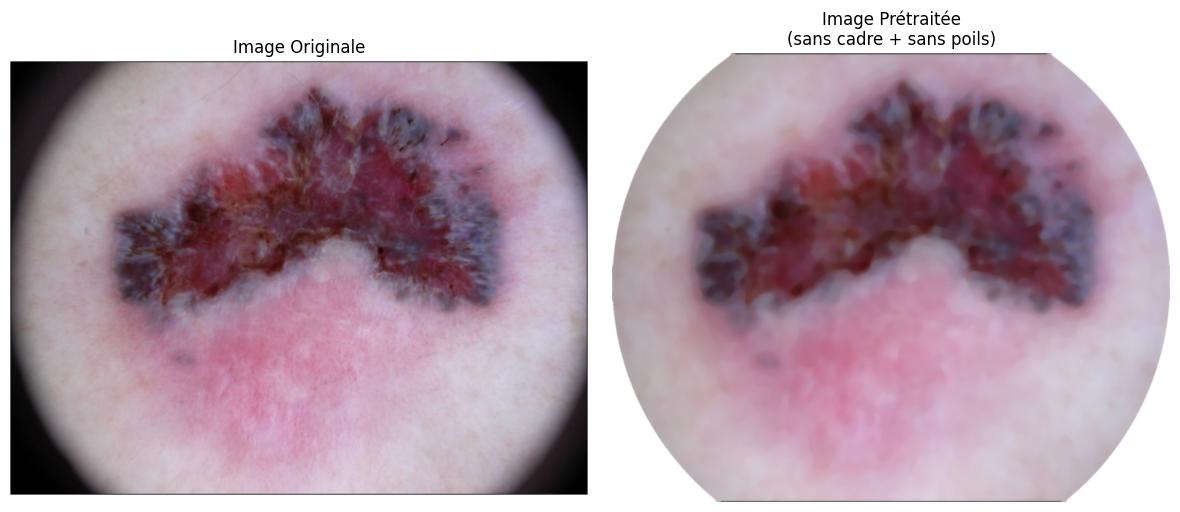

In [105]:
# Imports nécessaires
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# Charger une image de test
img_path = "../dataset/melanoma/ISIC_0000030.jpg"
img_original = io.imread(img_path)

print(f"Image originale chargée: {img_original.shape}")
print(f"Type: {img_original.dtype}")

# Appliquer le prétraitement (suppression cadre noir + poils)
print("\n=== PRÉTRAITEMENT ===")
img = preprocess_image(img_original, remove_frame=True, remove_hair=True, verbose=True)
print(f"Image prétraitée: {img.shape}")

# Afficher les images avant/après prétraitement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_original)
axes[0].set_title("Image Originale")
axes[0].axis('off')

axes[1].imshow(img)
axes[1].set_title("Image Prétraitée\n(sans cadre + sans poils)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 1. Méthode Otsu Multi-Canal

Application directe du seuillage d'Otsu sur différents canaux de couleur (rouge, vert, bleu, gris).
La méthode sélectionne automatiquement le meilleur canal selon un score composite.

=== SEGMENTATION OTSU MULTI-CANAL ===

✅ Segmentation terminée !
Meilleur canal: Optimized
Forme du masque: (1129, 1403)

✅ Segmentation terminée !
Meilleur canal: Optimized
Forme du masque: (1129, 1403)


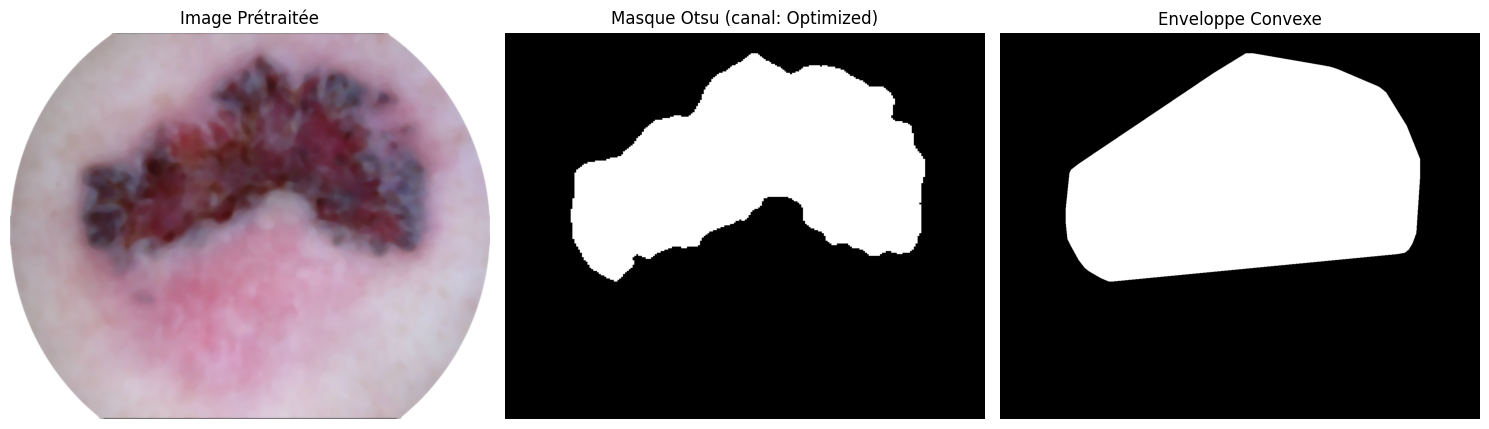

In [106]:
# =============================================================================
# MÉTHODE 1 : OTSU MULTI-CANAL (APPLICATION)
# =============================================================================
print("=== SEGMENTATION OTSU MULTI-CANAL ===")

mask_otsu, convex_hull_otsu, results_otsu = otsu_multi_channel_segmentation(
    img,
    channels=['red', 'green', 'blue', 'gray'],
    disk_size=3,
    selection_method='composite_score',
    verbose=True
)

print("\n✅ Segmentation terminée !")
print(f"Meilleur canal: {results_otsu['best_channel']}")
print(f"Forme du masque: {mask_otsu.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Image Prétraitée")
axes[0].axis('off')

axes[1].imshow(mask_otsu, cmap='gray')
axes[1].set_title(f"Masque Otsu (canal: {results_otsu['best_channel']})")
axes[1].axis('off')

axes[2].imshow(convex_hull_otsu, cmap='gray')
axes[2].set_title("Enveloppe Convexe")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 2. Méthode LBP Clustering

Pipeline complet avec extraction de caractéristiques LBP (Local Binary Patterns),
lissage gaussien, conversion Lab, clustering k-means et post-traitement morphologique.

=== SEGMENTATION LBP CLUSTERING ===

✅ Segmentation terminée!
Forme du masque: (1129, 1403)
Nombre de clusters: 2

✅ Segmentation terminée!
Forme du masque: (1129, 1403)
Nombre de clusters: 2


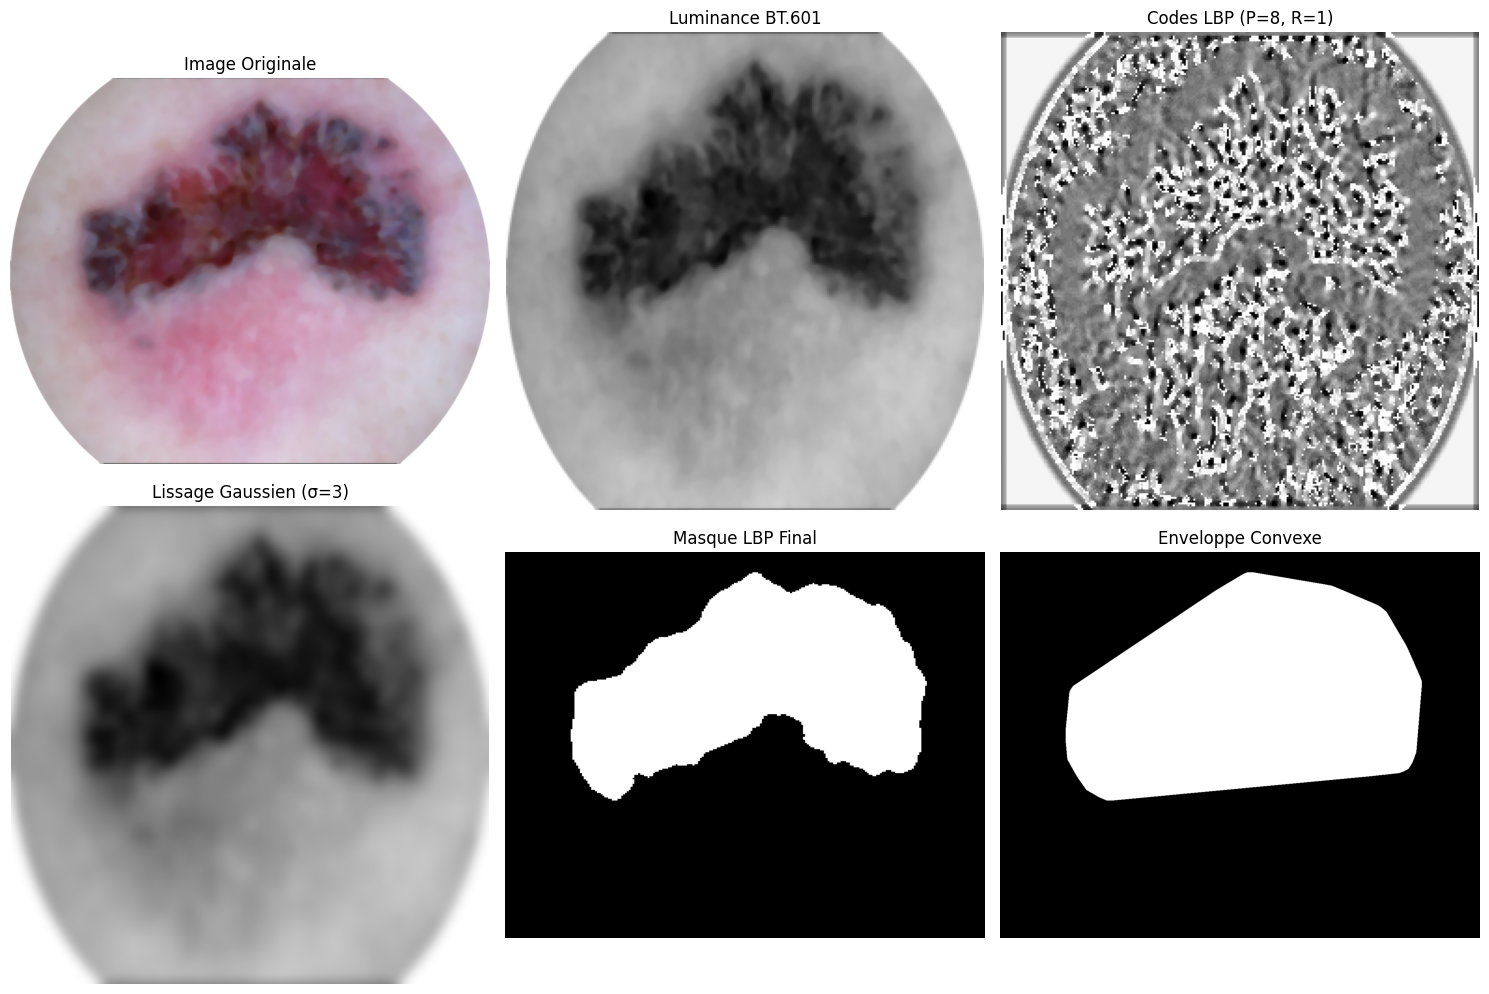

In [107]:
print("=== SEGMENTATION LBP CLUSTERING ===")

# Application de la méthode LBP avec prétraitement complet
mask_lbp, convex_hull_lbp, results_lbp = lbp_clustering_segmentation(
    img,
    sigma=3.0,
    disk_size=3,
    verbose=True
)

print(f"\n✅ Segmentation terminée!")
print(f"Forme du masque: {mask_lbp.shape}")
print(f"Nombre de clusters: {len(np.unique(results_lbp['cluster_labels']))}")

# Visualisation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Ligne 1: Pipeline principal
axes[0, 0].imshow(img)
axes[0, 0].set_title("Image Originale")
axes[0, 0].axis('off')

axes[0, 1].imshow(results_lbp['luminance'], cmap='gray')
axes[0, 1].set_title("Luminance BT.601")
axes[0, 1].axis('off')

axes[0, 2].imshow(results_lbp['lbp_codes'], cmap='gray')
axes[0, 2].set_title("Codes LBP (P=8, R=1)")
axes[0, 2].axis('off')

# Ligne 2: Résultats finaux
axes[1, 0].imshow(results_lbp['smoothed_L'], cmap='gray')
axes[1, 0].set_title("Lissage Gaussien (σ=3)")
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_lbp, cmap='gray')
axes[1, 1].set_title("Masque LBP Final")
axes[1, 1].axis('off')

axes[1, 2].imshow(convex_hull_lbp, cmap='gray')
axes[1, 2].set_title("Enveloppe Convexe")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 3. Méthode Statistical Region Merging (SRM)

Segmentation par fusion de régions basée sur des critères statistiques.
Le paramètre Q contrôle le nombre de régions (plus petit = moins de régions).

=== SEGMENTATION STATISTICAL REGION MERGING ===
SRM -> segments: 65 | threshold: 0.6475 | selected: 16

✅ Segmentation terminée!
Nombre total de régions: 65
Région sélectionnée: 16
Forme du masque: (1129, 1403)
SRM -> segments: 65 | threshold: 0.6475 | selected: 16

✅ Segmentation terminée!
Nombre total de régions: 65
Région sélectionnée: 16
Forme du masque: (1129, 1403)


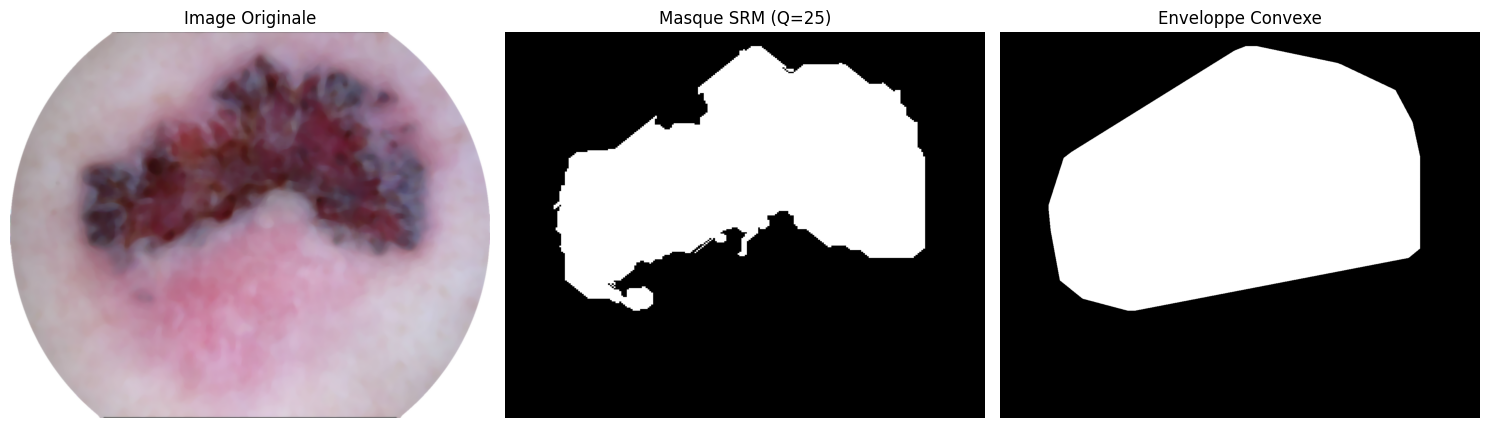

In [108]:
print("=== SEGMENTATION STATISTICAL REGION MERGING ===")

# Application de la méthode SRM avec post-traitement
# Réduire encore plus Q pour avoir BEAUCOUP moins de régions (fusion plus agressive)
mask_srm, convex_hull_srm, results_srm = srm_segmentation_with_postprocessing(
    img,
    Q=15,              # Paramètre d'échelle encore PLUS RÉDUIT (moins de régions)
    gaussian_sigma=2.0,  # Plus de lissage pour simplifier
    verbose=True        # Activer le mode verbose pour voir le scoring
)

print(f"\n✅ Segmentation terminée!")
print(f"Nombre total de régions: {len(np.unique(results_srm['labels']))}")
print(f"Région sélectionnée: {results_srm['selected_region_label']}")
print(f"Forme du masque: {mask_srm.shape}")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Image Originale")
axes[0].axis('off')

axes[1].imshow(mask_srm, cmap='gray')
axes[1].set_title(f"Masque SRM (Q=25)")
axes[1].axis('off')

axes[2].imshow(convex_hull_srm, cmap='gray')
axes[2].set_title("Enveloppe Convexe")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Comparaison Visuelle des 3 Méthodes

=== COMPARAISON DES 3 MÉTHODES ===


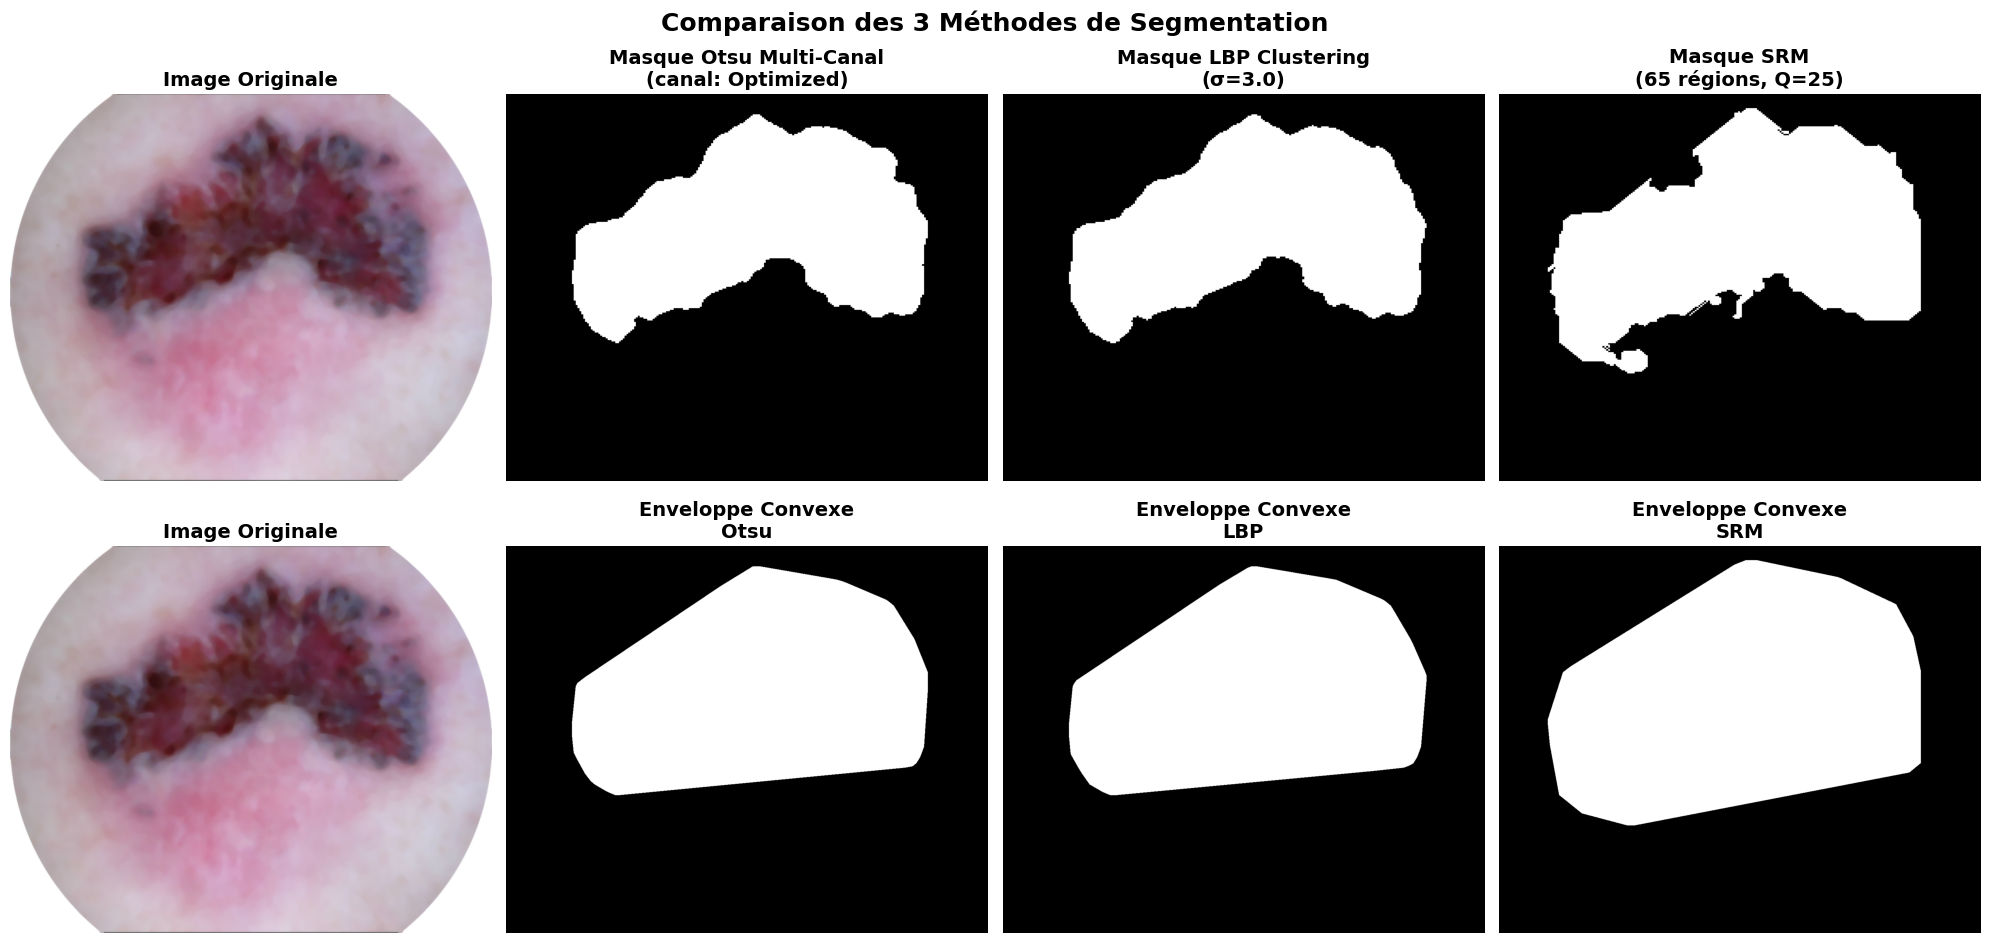


✅ Comparaison terminée!


In [109]:
print("=== COMPARAISON DES 3 MÉTHODES ===")

# Visualisation comparative
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Ligne 1: Image originale + 3 masques
axes[0, 0].imshow(img)
axes[0, 0].set_title("Image Originale", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_otsu, cmap='gray')
axes[0, 1].set_title(f"Masque Otsu Multi-Canal\n(canal: {results_otsu['best_channel']})", 
                  fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(mask_lbp, cmap='gray')
axes[0, 2].set_title(f"Masque LBP Clustering\n(σ=3.0)", 
                  fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(mask_srm, cmap='gray')
axes[0, 3].set_title(f"Masque SRM\n({len(np.unique(results_srm['labels']))} régions, Q=25)", 
                  fontsize=14, fontweight='bold')
axes[0, 3].axis('off')

# Ligne 2: Enveloppes convexes
axes[1, 0].imshow(img)
axes[1, 0].set_title("Image Originale", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(convex_hull_otsu, cmap='gray')
axes[1, 1].set_title("Enveloppe Convexe\nOtsu", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(convex_hull_lbp, cmap='gray')
axes[1, 2].set_title("Enveloppe Convexe\nLBP", fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(convex_hull_srm, cmap='gray')
axes[1, 3].set_title("Enveloppe Convexe\nSRM", fontsize=14, fontweight='bold')
axes[1, 3].axis('off')

plt.suptitle("Comparaison des 3 Méthodes de Segmentation", 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Comparaison terminée!")

In [110]:
# =============================================================================
# FONCTIONS D'ÉVALUATION (DICE & CHARGEMENT)
# =============================================================================
import os
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import resize


def compute_dice_score(mask_pred, mask_gt):
    """Calcule le coefficient de Dice entre deux masques binaires."""
    m1 = mask_pred > 0
    m2 = mask_gt > 0

    if m1.shape != m2.shape:
        m2 = resize(m2, m1.shape, order=0, mode="edge", anti_aliasing=False) > 0

    intersection = np.logical_and(m1, m2)

    if m1.sum() + m2.sum() == 0:
        return 1.0

    return 2.0 * intersection.sum() / (m1.sum() + m2.sum())


def get_ground_truth_path(image_path):
    """Retourne le chemin du masque associé (supporte *_Segmentation et *_segmentation)."""
    dirname, filename = os.path.split(image_path)
    name_no_ext = os.path.splitext(filename)[0]
    candidate_names = [
        f"{name_no_ext}_Segmentation.png",
        f"{name_no_ext}_segmentation.png",
    ]

    for candidate in candidate_names:
        candidate_path = os.path.join(dirname, candidate)
        if os.path.exists(candidate_path):
            return candidate_path

    return os.path.join(dirname, candidate_names[0])


print("✅ Fonctions Dice prêtes.")

✅ Fonctions Dice prêtes.


In [111]:
# ==========================================
# CONFIGURATION DES CHEMINS DU DATASET
# ==========================================
from pathlib import Path

DATASET_ROOT = Path("../dataset").resolve()
DATASET_SUBFOLDERS = ["melanoma", "nevus"]

image_paths = []
for subset in DATASET_SUBFOLDERS:
    subset_dir = DATASET_ROOT / subset
    if not subset_dir.exists():
        print(f"⚠️ Dossier introuvable : {subset_dir}")
        continue

    subset_images = sorted(str(p) for p in subset_dir.glob("*.jpg"))
    if not subset_images:
        print(f"⚠️ Aucun fichier .jpg trouvé dans {subset_dir}")

    image_paths.extend(subset_images)

print(f"{len(image_paths)} images détectées dans {DATASET_ROOT}.")

20 images détectées dans C:\Users\theop\Documents\Telecom_Paris\2A\cours\p1\IMA\projet_lesions_git\2026-im01-nadiedjoa-nadakumar\dataset.


Traitement de 20 images en cours...
Affichage des 5 premiers résultats seulement.



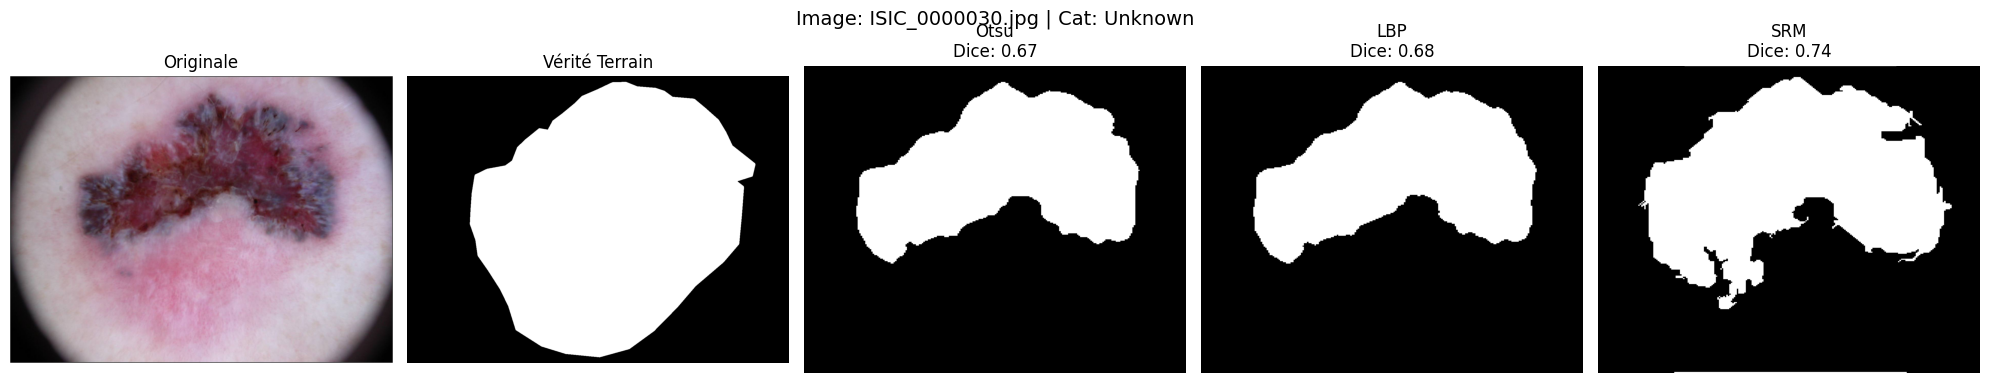

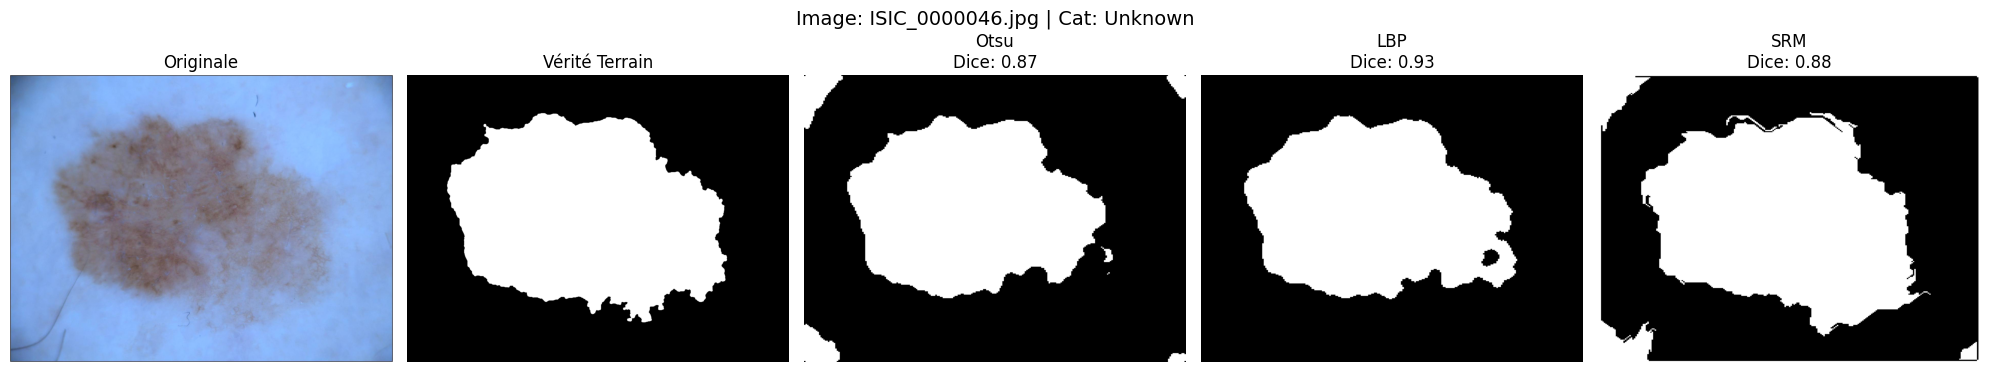

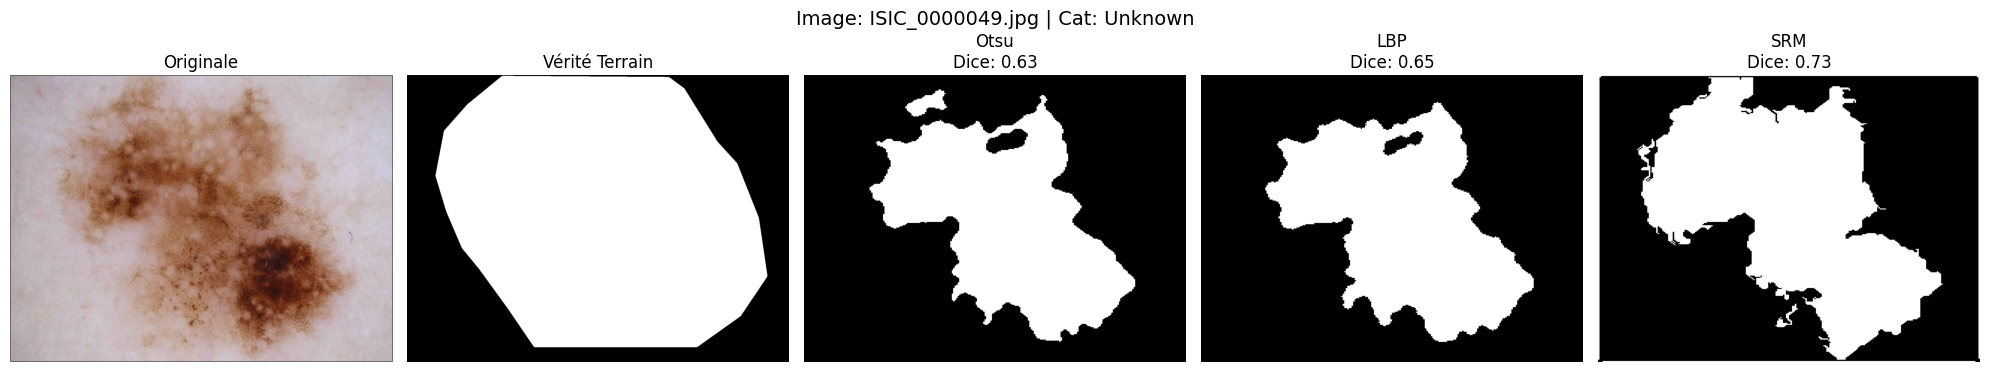

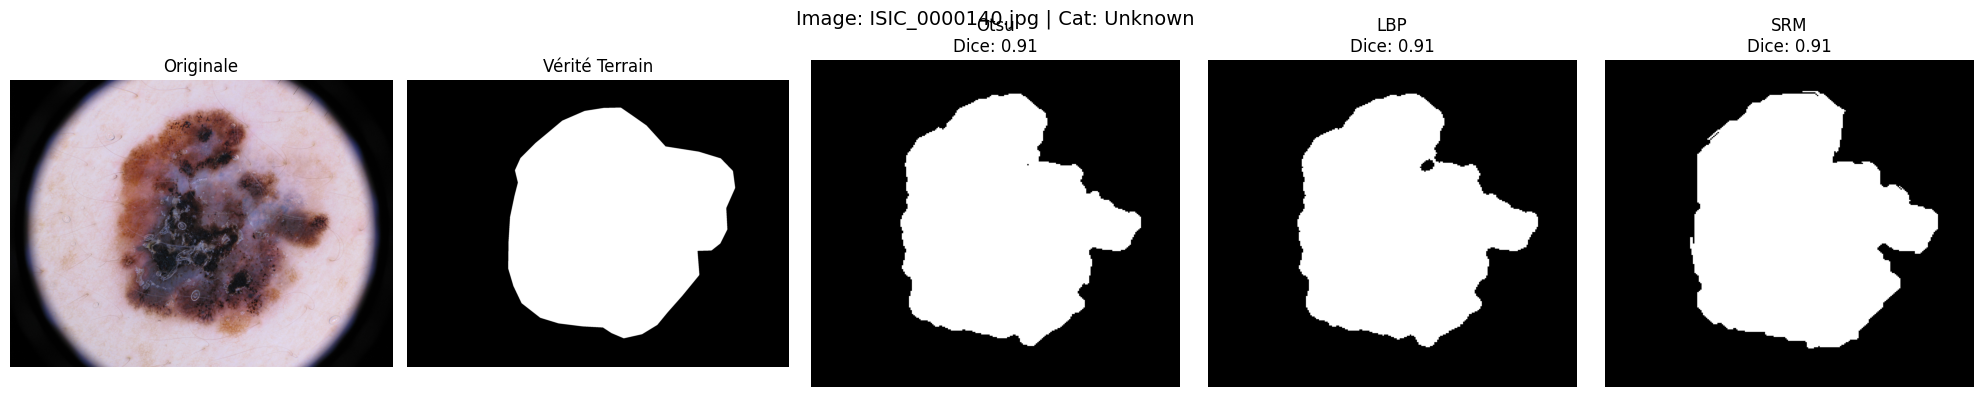

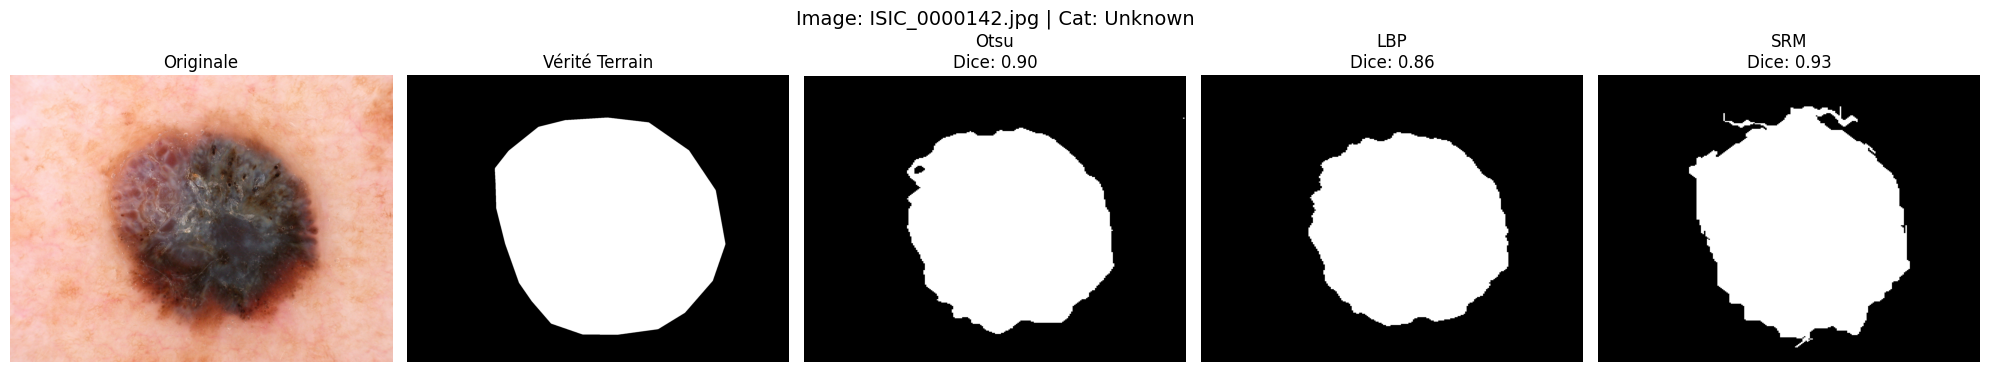


 MOYENNES GLOBALES (DICE) 
Otsu    0.827783
LBP     0.861217
SRM     0.815449
dtype: float64

 DÉTAIL DES RÉSULTATS (10 premiers) 


Image Category      Otsu       LBP       SRM
0  ISIC_0000030.jpg  Unknown  0.674222  0.675442  0.735934
1  ISIC_0000046.jpg  Unknown  0.866954  0.931561  0.881801
2  ISIC_0000049.jpg  Unknown  0.631905  0.647129  0.726691
3  ISIC_0000140.jpg  Unknown  0.911430  0.908515  0.906073
4  ISIC_0000142.jpg  Unknown  0.900345  0.857142  0.930850
5  ISIC_0000143.jpg  Unknown  0.707220  0.720991  0.868710
6  ISIC_0000145.jpg  Unknown  0.986415  0.991526  0.975885
7  ISIC_0000146.jpg  Unknown  0.882795  0.907314  0.901406
8  ISIC_0000150.jpg  Unknown  0.814396  0.772848  0.881538
9  ISIC_0000151.jpg  Unknown  0.826918  0.857688  0.900707

In [ ]:
# ==========================================
# VISUALISATION ET COMPARAISON FINALE
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage.transform import resize
from skimage.segmentation import felzenszwalb
import numpy as np
import os

# Configuration
MAX_DISPLAY = 5  # Limite l'affichage aux 5 premières images pour ne pas surcharger
results = [] 

print(f"Traitement de {len(image_paths)} images en cours...")
print(f"Affichage des {MAX_DISPLAY} premiers résultats seulement.\n")

for idx, img_path in enumerate(image_paths):
    
    # 1. Chargement
    img_name = os.path.basename(img_path)
    img = io.imread(img_path)
    
    # Utilisation de la fonction helper définie plus haut pour trouver le masque
    mask_path = get_ground_truth_path(img_path)
            
    if not os.path.exists(mask_path):
        print(f"⚠️ Masque introuvable pour {img_name}, ignoré.")
        continue
        
    gt_mask = io.imread(mask_path)
    # Binarisation propre du GT
    if gt_mask.ndim == 3: gt_mask = gt_mask[:,:,0]
    gt_mask = (gt_mask > 127).astype(np.uint8)

    # 2. Prétraitement
    img_pre = preprocess_image(img, remove_frame=True, remove_hair=True, verbose=False)
    
    # 3. Calcul des Segmentations
    
    # Otsu
    m_otsu, _, _ = otsu_multi_channel_segmentation(img_pre)
    
    # LBP (Nouvelle version rapide)
    m_lbp, _, _ = lbp_clustering_segmentation(img_pre)
    
    # SRM (Version inline rapide pour garantir le fonctionnement)
    srm_small = resize(img_pre, (256, 256), anti_aliasing=True)
    segments_srm = felzenszwalb(srm_small, scale=100, sigma=0.5, min_size=50)
    # Binarisation simple sur moyenne (Lésion sombre)
    srm_gray = srm_small.mean(axis=2)
    srm_mask_small = np.zeros_like(srm_gray)
    for seg_id in np.unique(segments_srm):
        if srm_gray[segments_srm == seg_id].mean() < srm_gray.mean(): 
            srm_mask_small[segments_srm == seg_id] = 1
    m_srm = resize(srm_mask_small, img_pre.shape[:2], order=0)
    m_srm = (m_srm > 0.5).astype(np.uint8)
    
    # Remplissage des trous pour SRM inline
    from scipy.ndimage import binary_fill_holes
    m_srm = binary_fill_holes(m_srm).astype(np.uint8)

    # 4. Calcul Dice
    d_otsu = compute_dice_score(m_otsu, gt_mask)
    d_lbp  = compute_dice_score(m_lbp, gt_mask)
    d_srm  = compute_dice_score(m_srm, gt_mask)
    
    # Stockage
    category = "Unknown" 
    if 'metadata' in locals() and not metadata.empty:
        match = metadata.loc[metadata['image_id'] == img_name[:-4]]
        if not match.empty: category = match['dx'].values[0]

    results.append({
        "Image": img_name, "Category": category,
        "Otsu": d_otsu, "LBP": d_lbp, "SRM": d_srm
    })

    # ==========================================
    # AFFICHAGE VISUEL
    # ==========================================
    if idx < MAX_DISPLAY:
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        plt.suptitle(f"Image: {img_name} | Cat: {category}", fontsize=14)
        
        # Original
        axes[0].imshow(img)
        axes[0].set_title("Originale")
        axes[0].axis('off')
        
        # GT
        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Vérité Terrain")
        axes[1].axis('off')
        
        # Otsu
        axes[2].imshow(m_otsu, cmap='gray')
        axes[2].set_title(f"Otsu\nDice: {d_otsu:.2f}")
        axes[2].axis('off')
        
        # LBP
        axes[3].imshow(m_lbp, cmap='gray')
        axes[3].set_title(f"LBP\nDice: {d_lbp:.2f}")
        axes[3].axis('off')
        
        # SRM
        axes[4].imshow(m_srm, cmap='gray')
        axes[4].set_title(f"SRM\nDice: {d_srm:.2f}")
        axes[4].axis('off')
        
        plt.tight_layout()
        plt.show()

# --- Résumé Final ---
if results:
    df = pd.DataFrame(results)
    print("\n" + "="*30)
    print(" MOYENNES GLOBALES (DICE) ")
    print("="*30)
    print(df[["Otsu", "LBP", "SRM"]].mean())
    
    print("\n" + "="*30)
    print(" DÉTAIL DES RÉSULTATS (10 premiers) ")
    print("="*30)
    display(df.head(10))
else:
    print("Aucun résultat généré.")